# MNIST Image Generator Using GANs

Generative adversarial networks (GANs) are an exciting recent innovation in machine learning. GANs are generative models: they create new data instances that resemble your training data. For example, GANs can create images that look like photographs of human faces, even though the faces do not belong to any real person. You can examine the GANs architecture below. In this notebook, we create new images using the MNIST dataset.

<div align = "center">
<img title="GANs Architecture" alt="Alt text" src="https://sthalles.github.io/assets/dcgan/GANs.png" width = 800 height = 500>
</div>

**Note**: If you want to learn detailed information about the GANs architecture, you can follow the following link: https://developers.google.com/machine-learning/gan/gan_structure?hl=en

## Image Preprocessing

Let's first import the required libraries and the dataset.

In [1]:
# import the required libraries

# to create the model
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam

# dataset
from keras.datasets import mnist

# to create noise
import numpy as np

# to visualize
import matplotlib.pyplot as plt

In [2]:
# import the dataset

(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

shapeOfImgs = xTrain[0].shape

print("xTrain Shape:", xTrain.shape)
print("xTest Shape:", xTest.shape)
print("yTrain Shape:", yTrain.shape)
print("yTest Shape:", yTest.shape)

11490434/11490434 [==============================] - 2s 0us/step
xTrain Shape: (60000, 28, 28)
xTest Shape: (10000, 28, 28)
yTrain Shape: (60000,)
yTest Shape: (10000,)


The MNIST dataset can be gotten from Keras easily like above. Now, let's look at some examples from the dataset.

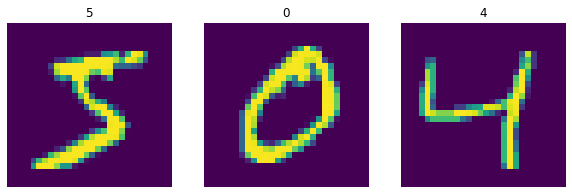

In [3]:
# visualize some of the images

fig, ax = plt.subplots(1, 3, figsize = (10, 4))

ax[0].imshow(xTrain[0])
ax[0].set_title(yTrain[0])
ax[0].axis("off")

ax[1].imshow(xTrain[1])
ax[1].set_title(yTrain[1])
ax[1].axis("off")

ax[2].imshow(xTrain[2])
ax[2].set_title(yTrain[2])
ax[2].axis("off")

plt.show()

Now, we need to normalize and flatten the data. Then we can start to create our GANs model.

In [4]:
# normalize and flatten the data

xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
xTrain = xTrain.reshape(-1, xTrain.shape[1] * xTrain.shape[2])

xTest = (xTest.astype(np.float32) - 127.5) / 127.5
xTest = xTest.reshape(-1, xTest.shape[1] * xTest.shape[2])

print("xTrain Shape:", xTrain.shape)
print("xTest Shape:", xTest.shape)

xTrain Shape: (60000, 784)
xTest Shape: (10000, 784)


## Model Building

Firstly, we need to build the generator, which is a basic neural network model. The generator creates images that do not belong to the dataset using noise. 

In [5]:
# create the generator

def create_generator():
    generator = Sequential()
    generator._name = "generator"
    
    generator.add(Dense(512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(512))
    generator.add(ReLU())
    
    generator.add(Dense(1024))
    generator.add(ReLU())
    
    generator.add(Dense(shapeOfImgs[0] * shapeOfImgs[1]))

    generator.compile(loss = "binary_crossentropy", 
                      optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))
    
    return generator

generator = create_generator()

print(generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               80

You can look at the structure of the generator above. Now, let's build the discriminator, which is also a neural network model that tries to distinguish real from fake data.

In [6]:
# create the discriminator

def create_discriminator():
    discriminator = Sequential()
    discriminator._name = "discriminator"
    
    discriminator.add(Dense(1024, input_dim = shapeOfImgs[0] * shapeOfImgs[1]))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(256))
    discriminator.add(ReLU())
    
    discriminator.add(Dense(1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy", 
                          optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))
    
    return discriminator

discriminator = create_discriminator()

print(discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)             

Now, we are ready to create our GANs model by using the generator and discriminator. The main purpose of GANs model is to deceive the discriminator. That means that the generator should create such data that the discriminator cannot determine whether it is real or fake.

In [7]:
# create the GANs

def create_gan(discriminator, generator):
    discriminator.trainable = False
    
    ganInput = Input(shape = (100,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    
    gan = Model(inputs = ganInput, outputs = ganOutput)
    gan._name = "gan"
    
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    
    return gan
    
gan = create_gan(discriminator, generator)

print(gan.summary())

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 784)               1643280   
                                                                 
 discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________
None


Let's define the number of epochs and batch size for the training process.

In [8]:
# define the number of epochs and batch size

numOfEpochs = 100
batchSize = 256

Let's start training the model. When training it, we need to train two models, which are the generator and discriminator. Unlike other AI models, the training process of GANs is a little bit different. Let me explain the process briefly. First, we need to create some noise as an input for the generator. Then, we need to get output from the generator to feed the discriminator. After that, the discriminator needs to be fed with the image from the MNIST dataset and the output gotten from the generator. Thanks to these inputs, the discriminator can train itself to distinguish between real and fake images. Up until this step, we talked about the training process of the discriminator. Now, let's continue with the training process of the generator. Recall that the purpose of the generator is to deceive the discriminator, so it needs to get some feedback from the discriminator about whether the generator can achieve this or not. In this way, the generator can also train itself. However, there is a crucial point here. We need to arrange the discriminator as a non-trainable model to avoid training two models simultaneously, which is not a desired circumstance. Now, let's code.

In [9]:
# train the model

for e in range(numOfEpochs):
    print("Epoch", e + 1)
    
    for _ in range(batchSize):
        noise = np.random.normal(0, 1, [batchSize, 100])
        
        imgBatch = xTrain[np.random.randint(low = 0, 
                                            high = xTrain.shape[0], 
                                            size = batchSize)]
        generatedImgs = generator.predict(noise)
        
        x = np.concatenate([imgBatch, generatedImgs])
                          
        yDisFake = np.zeros(batchSize)
        yDisReal = np.ones(batchSize)
                          
        yDis = np.concatenate([yDisReal, yDisFake])
                          
        discriminator.trainable = True
        discriminator.train_on_batch(x, yDis)
        
        noise = np.random.normal(0, 1, [batchSize, 100])
        
        yGen = np.ones(batchSize)
        
        discriminator.trainable = False
        gan.train_on_batch(noise, yGen)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
8/8 [==============================] - 0s 4ms/step
Epoch 82
8/8 [==============================] - 0s 3ms/step
Epoch 83
8/8 [==============================] - 0s 2ms/step
Epoch 84
8/8 [==============================] - 0s 5ms/step
Epoch 85
8/8 [==============================] - 0s 3ms/step
Epoch 86
8/8 [==============================] - 0s 4ms/step
Epoch 87
8/8 [==============================] - 0s 4ms/step
Epoch 88
8/8 [==============================] - 0s 3ms/step
Epoch 89
8/8 [==============================] - 0s 4ms/step
Epoch 90
8/8 [==============================] - 0s 3ms/step
Epoch 91
8/8 [==============================] - 0s 3ms/step
Epoch 92
8/8 [==============================] - 0s 2ms/step
Epoch 93
8/8 [==============================] - 0s 4ms/step
Epoch 94
8/8 [==============================] - 0s 3ms/step
Epoch 95
8/8 [==============================] - 0s 4ms/step
Epoch 96
8/8 [==============================] - 0s 3ms/step
Ep

The training process is done. Now, we can look at some sample output of our model.

4/4 [==============================] - 0s 3ms/step


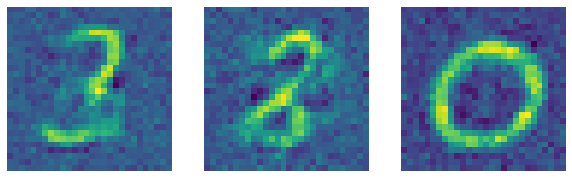

In [11]:
# visualize the results

noise = np.random.normal(loc = 0, scale = 1, size = [100, 100])

generatedImgs = generator.predict(noise)
generatedImgs = generatedImgs.reshape(100, shapeOfImgs[0], shapeOfImgs[1])

fig, ax = plt.subplots(1, 3, figsize = (10, 4))

ax[0].imshow(generatedImgs[66], interpolation = "nearest")
ax[0].axis("off")

ax[1].imshow(generatedImgs[67], interpolation = "nearest")
ax[1].axis("off")

ax[2].imshow(generatedImgs[68], interpolation = "nearest")
ax[2].axis("off")

plt.show()

As seen, the model can create some images that do not belong to the MNIST dataset. However, they are still distinguishable, so you can improve the model to get more successfull results.

In [12]:
generator.save("mnist_generator.h5")

## Conclusion

In this notebook, we built a basic GANs model to create new MNIST images. Our outputs are not perfect, but they are sufficient to show the logic of GANs models. If you want to improve your knowledge and learn usage areas of GANs, I highly recommend you visit the following links:
* https://arxiv.org/pdf/1708.05509.pdf
* https://arxiv.org/pdf/1609.04802.pdf
* https://arxiv.org/pdf/1704.04086.pdf
* https://github.com/pathak22/context-encoder
* https://github.com/hanzhanggit/StackGAN